In [3]:
from collections import deque
from functools import lru_cache
from itertools import accumulate, product

import gmpy2
import numpy as np
from scipy.stats import binom

from typing import Tuple
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, bisect
from communityaware.cert import isotropic
from statsmodels.stats.proportion import proportion_confint

# Best case $p_A$

We plot the error $1-p_A$. After some number of samples the slope looks like $1$ on the log-log axis suggesting $1-p_A$ is linear with the number of samples

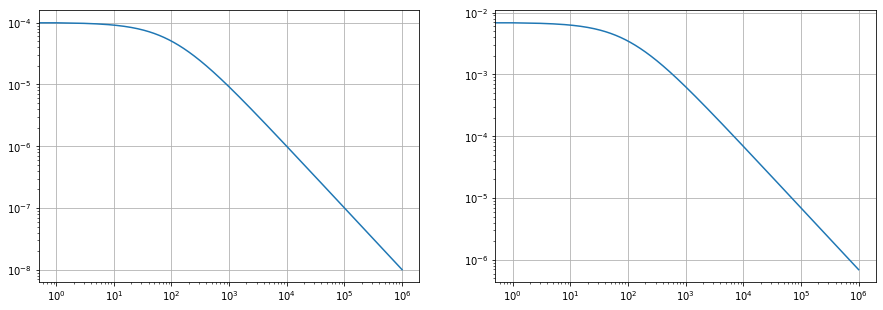

In [4]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(15, 5))
confidence_level = 0.99
p_A = proportion_confint(np.arange(100, 1000000), np.arange(100, 1000000), alpha=2 * confidence_level, method='beta')[0]
axs[0].plot(1-p_A)
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].grid()

confidence_level = 0.5
p_A = proportion_confint(np.arange(100, 1000000), np.arange(100, 1000000), alpha=2 * confidence_level, method='beta')[0]
axs[1].plot(1-p_A)
axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].grid()

# Best case certificates

## Wang

In Figure 1 they get good radius for when the noise parameter is $0.3$. We can see if they wanted to certify to $r=10$ they would need $p_A = 0.995$ which is not surprising they didnt get under such large levels of noise

In [5]:
def find_p_A_isotropic(p, r, eps=10e-10):
    sol, rootresults = bisect(lambda p_A: float(isotropic(r, p, p_A))-0.5, 0+eps, 1-eps, full_output=True)
    assert rootresults.converged
    return sol

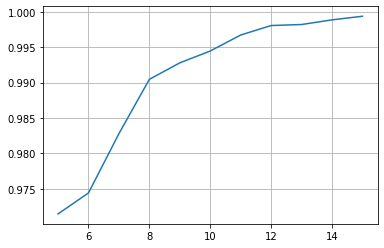

In [6]:
fig, ax = plt.subplots()
rs = np.arange(5, 16)
ax.plot(rs, [find_p_A_isotropic(0.3, r) for r in rs])
ax.grid()

# Symmetry on p

What happens when $p=0.5$? Is noise level of $0.3$ and $0.7$ the same or related?

In [7]:
def maxR(p, p_A=0.99):
    try:
        return np.where([float(isotropic(x, p, p_A)) > 0.5 for x in np.arange(1, 1000)])[0][-1]+1
    except:
        return np.nan

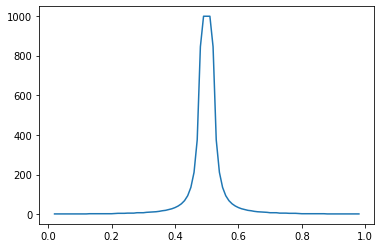

In [8]:
# this takes about 6 minutes

step = 0.01
ps = np.arange(step, 1, step)
fig, ax = plt.subplots()
ax.plot(ps, [maxR(p) for p in ps])

In [9]:
fig, ax = plt.subplots()
for p_A in [0.9, 0.99, 0.999]:
    ps = np.arange(0.05, 0.5, 0.01)[:-5]
    Rs = [maxR(p, p_A) for p in ps]
    ax.plot(Rs, ps, label=p_A)
fig.legend()
fig

In [ ]:
from communityaware.cert import compute_certificate_gmpy
from scipy.optimize import minimize_scalar
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def getdata(p_A, R):
    p1 = np.arange(0.01, 0.5, 0.001)
    data = []
    for p in p1:
        sol = minimize_scalar(lambda x: np.abs(float(compute_certificate_gmpy(R, (p, x), p_A))-0.5), bounds=(0.0001, 0.51), method='bounded')
        data.append((p, sol.x, sol.success, sol.fun))
    data = np.array(data)
    return data

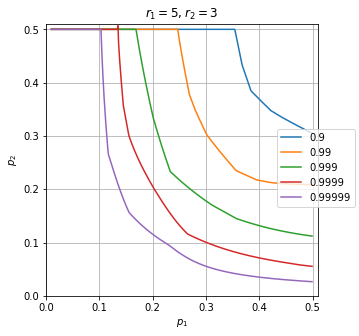

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
R = (5, 3)
for p_A in [0.9, 0.99, 0.999, 0.9999, 0.99999]:
    data = getdata(p_A, R)
    assert np.all(data[:, 2]) # checks all optimisations converged... 
    ax.plot(data[:, 0], data[:, 1], label=p_A)

ax.set_xlim(0, 0.51)
ax.set_ylim(0, 0.51)
ax.set_xlabel(r'$p_1$')
ax.set_ylabel(r'$p_2$')
ax.set_aspect('equal', adjustable='box')
ax.grid()
ax.set_title(r'$r_1=5, r_2=3$')
fig.legend(loc='right')

Isotropic

In [ ]:
from scipy.stats import binom
from scipy.special import betainc
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def region(q, R, p):
    return ((1-p)/p)**(R-2*q)


In [ ]:
R = 5
p = 0.2
q = 1
p_A = 0.6723199999999999

binom.pmf(R-q, R, p)

0.0064

We consider no partial regions and notice that $a^\star$ is $4$ as the below sum is $p_A$

In [ ]:
np.isclose(binom.pmf(0, R, 1-p) + binom.pmf(1, R, 1-p) + binom.pmf(2, R, 1-p) + binom.pmf(3, R, 1-p)  + binom.pmf(4, R, 1-p), p_A)
a_star = 4

We can write $a^\star$ as the solution to the following equation

$$I_p(R-a^\star, a^\star+1) = p_A$$

Where $I$ is the incomplete beta function. Just a note that 

$$I_p(R-a^\star, a^\star+1) = 1 - I_{1-p}(a^\star+1, R-a^\star)

In [ ]:
print(np.isclose(betainc(R-a_star, a_star+1, p), p_A))
print(np.isclose(betainc(R-a_star, a_star+1, p), 1-betainc(a_star+1, R-a_star, 1-p)))

True
True


Once we have $a^{\star}$ we compute the following 

$$\sum\limits_{q=0}^{a^\star} Bin(R, q, p)$$

Which is equal to 

$$\sum\limits_{q=0}^{a^\star} Bin(R, q, p) = I_{1-p}(R-a^\star, a^\star+1)$$

The certificate reduces to if $I_{1-p}(R-a^\star, a^\star+1) > 0.5$ given that $I_p(R-a^\star, a^\star+1) = p_A$.

By finding $a^\star$ such that $I_p(R-a^\star, a^\star+1) = p_A$ we can plug it into $I_{1-p}(R-a^\star, a^\star+1)$ and check if its above $0.5$.

Note that $1-p_A = 1 - I_p(R-a^\star, a^\star+1) = I_{1-p}(a^\star+1, R-a^\star)$

In [ ]:
from scipy.optimize import minimize_scalar

def findastar(R, p, p_A):
    sol = minimize_scalar(lambda x: np.abs(betainc(R-x, x+1, p) - p_A), bounds=(0, R), method='bounded')
    assert sol.success
    return sol.x

In [ ]:
findastar(R, p, p_A)

3.999999082206481

Perhaps we look instead at number of samples and alpha instead of pA

In [ ]:
from statsmodels.stats.proportion import proportion_confint

n = 1000
confidence_level = 0.95

p_A = proportion_confint(int(0.9*n), n, alpha=2 * confidence_level, method='beta')[0]
p_A

0.9142865160321019

In [ ]:
isotropic(5, 0.5, 0.9)

mpfr('0.90000000000000002220446049250313',100)

In [ ]:
from communityaware.cert import isotropic
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
p_A = 0.9
ps = np.arange(0.01, 1, 0.01)

In [ ]:
def maxR(p, p_A):
    for r in range(1000):
        if isotropic(r, p, p_A) < 0.5:
            return r - 1
    else:
        return 1000

In [ ]:
p=0.1

p_As = np.arange(0.5, 1, 0.001)

In [ ]:
data = []
for p in np.arange(0.05, 0.45, 0.05):
    for p_A in p_As:
        data.append((p, p_A, maxR(p, p_A)))

In [ ]:
data = pd.DataFrame(data, columns=['p', 'p_A', 'maxR'])

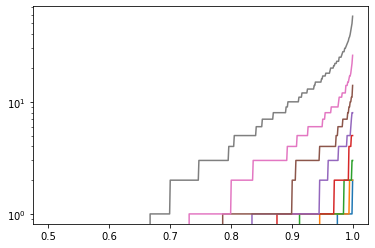

In [ ]:
fig, ax = plt.subplots()
for p in data['p'].unique():
    ax.plot(data.query(f'p=={p}')['p_A'], data.query(f'p=={p}')['maxR'])
ax.set_yscale('log')

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45])